# Домашнее задание

ML разработчикам необходимо не только уметь обучать нейронные сети и генерировать новые идеи, но еще и уметь в страивать наработки в pipeline. В этом домашнем задании нам предстоит сделать из frustum детектора production ready (ну почти) решение, которое может работать на сырых данных.

К сожалению, frustum-pointnet работает независимо для каждой 2D детекции. В этом домашнем задании вам предстоит написать обертку над frustum-pointnet, которая будет работать над целыми облаками. Вам также нужно будет воспользоваться 2D детектором, чтобы находить коробки на изображении.

Во второй части задания вам нужно будет написать оценку качества работы вашего алгоритма, которая становится чуть сложнее, когда на сцене могут находится много объектов.

## Часть 1

Ниже написан класс, который вам нужно реализовать. Чтобы воспользоваться предобученной сетью, позаимствуйте код из
https://github.com/charlesq34/frustum-pointnets/blob/master/train/test.py

Предобученные модели лежат здесь: https://shapenet.cs.stanford.edu/media/frustum_pointnets_snapshots.zip

В частности, вам нужно модифицировать функцию `get_session_and_ops` - функция должна уметь работать без глобальных флагов. После этого посмотрите, как эта функция используется.
Выход сети преобразуется в понятный формат в функции `write_detection_results`.

In [1]:
import os 
import sys
import numpy as np
import tensorflow as tf

from ssd import SSD
from collections import namedtuple
from matplotlib import pyplot as plt 

In [2]:
from frustum_pointnets.kitti import kitti_util as utils
from frustum_pointnets.models.model_util import placeholder_inputs
from frustum_pointnets.models.frustum_pointnets_v1 import get_model, get_loss
from frustum_pointnets.train.provider import from_prediction_to_label_format

In [3]:
NUM_CLASSES = 2
NUM_HEADING_BIN = 12
NUM_POINTS = 1024
NUM_SIZE_CLUSTER = 8
MODEL_PATH = 'frustum_pointnets_snapshots/log_v1/model.ckpt'
DATASET_PATH = 'kitti_dataset'

### Класс для чтения данных

In [4]:
class kitti_object:
    '''Load and parse object data into a usable format.'''
    
    def __init__(self, root_dir, split='training'):
        '''root_dir contains training and testing folders'''
        self.root_dir = root_dir
        self.split = split
        self.split_dir = os.path.join(root_dir, split)

        if split == 'training':
            self.num_samples = 7481
        elif split == 'testing':
            self.num_samples = 7518
        else:
            print('Unknown split: %s' % (split))
            exit(-1)

        self.image_dir = os.path.join(self.split_dir, 'image_2')
        self.calib_dir = os.path.join(self.split_dir, 'calib')
        self.lidar_dir = os.path.join(self.split_dir, 'velodyne')
        self.label_dir = os.path.join(self.split_dir, 'label_2')

    def __len__(self):
        return self.num_samples

    def get_image(self, idx):
        assert(idx<self.num_samples) 
        img_filename = os.path.join(self.image_dir, '%06d.png'%(idx))
        return utils.load_image(img_filename)

    def get_lidar(self, idx): 
        assert(idx<self.num_samples) 
        lidar_filename = os.path.join(self.lidar_dir, '%06d.bin'%(idx))
        return utils.load_velo_scan(lidar_filename)

    def get_calibration(self, idx):
        assert(idx<self.num_samples) 
        calib_filename = os.path.join(self.calib_dir, '%06d.txt'%(idx))
        return utils.Calibration(calib_filename)

    def get_label_objects(self, idx):
        assert(idx<self.num_samples and self.split=='training') 
        label_filename = os.path.join(self.label_dir, '%06d.txt'%(idx))
        return utils.read_label(label_filename)
        
    def get_depth_map(self, idx):
        pass

    def get_top_down(self, idx):
        pass

In [5]:
idx=8
data = kitti_object(DATASET_PATH)

image_test = data.get_image(idx)
xyzi_test = data.get_lidar(idx)
calib_test = data.get_calibration(idx)
label_test = data.get_label_objects(idx)

### Уберем глобальные флаги из функции get_session_and_ops и добавим все необходимые в дальнейшем функции

In [6]:
def get_session_and_ops(batch_size, num_point):
    ''' Define model graph, load model parameters,
    create session and return session handle and tensors
    '''
    with tf.Graph().as_default():
        with tf.device('/gpu:0'):
            pointclouds_pl, one_hot_vec_pl, labels_pl, centers_pl, \
            heading_class_label_pl, heading_residual_label_pl, \
            size_class_label_pl, size_residual_label_pl = placeholder_inputs(batch_size, num_point)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            end_points = get_model(pointclouds_pl, one_hot_vec_pl, is_training_pl)
            loss = get_loss(labels_pl, centers_pl,
                heading_class_label_pl, heading_residual_label_pl,
                size_class_label_pl, size_residual_label_pl, end_points)
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)

        # Restore variables from disk.
        saver.restore(sess, MODEL_PATH)
        ops = {'pointclouds_pl': pointclouds_pl,
               'one_hot_vec_pl': one_hot_vec_pl,
               'labels_pl': labels_pl,
               'centers_pl': centers_pl,
               'heading_class_label_pl': heading_class_label_pl,
               'heading_residual_label_pl': heading_residual_label_pl,
               'size_class_label_pl': size_class_label_pl,
               'size_residual_label_pl': size_residual_label_pl,
               'is_training_pl': is_training_pl,
               'logits': end_points['mask_logits'],
               'center': end_points['center'],
               'end_points': end_points,
               'loss': loss}
        return sess, ops

def softmax(x):
    ''' Numpy function for softmax'''
    shape = x.shape
    probs = np.exp(x - np.max(x, axis=len(shape)-1, keepdims=True))
    probs /= np.sum(probs, axis=len(shape)-1, keepdims=True)
    return probs

def inference(sess, ops, pc, one_hot_vec, batch_size):
    ''' Run inference for frustum pointnets in batch mode '''
    assert pc.shape[0]%batch_size == 0
    num_batches = pc.shape[0]//batch_size
    logits = np.zeros((pc.shape[0], pc.shape[1], NUM_CLASSES))
    centers = np.zeros((pc.shape[0], 3))
    heading_logits = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    heading_residuals = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    size_logits = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER))
    size_residuals = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER, 3))
    scores = np.zeros((pc.shape[0],)) # 3D box score 
   
    ep = ops['end_points'] 
    for i in range(num_batches):
        feed_dict = {\
            ops['pointclouds_pl']: pc[i*batch_size:(i+1)*batch_size,...],
            ops['one_hot_vec_pl']: one_hot_vec[i*batch_size:(i+1)*batch_size,:],
            ops['is_training_pl']: False}

        batch_logits, batch_centers, \
        batch_heading_scores, batch_heading_residuals, \
        batch_size_scores, batch_size_residuals = \
            sess.run([ops['logits'], ops['center'],
                ep['heading_scores'], ep['heading_residuals'],
                ep['size_scores'], ep['size_residuals']],
                feed_dict=feed_dict)

        logits[i*batch_size:(i+1)*batch_size,...] = batch_logits
        centers[i*batch_size:(i+1)*batch_size,...] = batch_centers
        heading_logits[i*batch_size:(i+1)*batch_size,...] = batch_heading_scores
        heading_residuals[i*batch_size:(i+1)*batch_size,...] = batch_heading_residuals
        size_logits[i*batch_size:(i+1)*batch_size,...] = batch_size_scores
        size_residuals[i*batch_size:(i+1)*batch_size,...] = batch_size_residuals

        # Compute scores
        batch_seg_prob = softmax(batch_logits)[:,:,1] # BxN
        batch_seg_mask = np.argmax(batch_logits, 2) # BxN
        mask_mean_prob = np.sum(batch_seg_prob * batch_seg_mask, 1) # B,
        mask_mean_prob = mask_mean_prob / np.sum(batch_seg_mask,1) # B,
        heading_prob = np.max(softmax(batch_heading_scores),1) # B
        size_prob = np.max(softmax(batch_size_scores),1) # B,
        batch_scores = np.log(mask_mean_prob) + np.log(heading_prob) + np.log(size_prob)
        scores[i*batch_size:(i+1)*batch_size] = batch_scores 
        # Finished computing scores

    heading_cls = np.argmax(heading_logits, 1) # B
    size_cls = np.argmax(size_logits, 1) # B
    heading_res = np.array([heading_residuals[i,heading_cls[i]] \
        for i in range(pc.shape[0])])
    size_res = np.vstack([size_residuals[i,size_cls[i],:] \
        for i in range(pc.shape[0])])

    return np.argmax(logits, 2), centers, heading_cls, heading_res, \
        size_cls, size_res, scores

def get_lidar_in_image_fov(pc_velo, calib, xmin, ymin, xmax, ymax,
                           return_more=False, clip_distance=2.0):
    ''' Filter lidar points, keep those in image FOV '''
    pts_2d = calib.project_velo_to_image(pc_velo)
    fov_inds = (pts_2d[:,0]<xmax) & (pts_2d[:,0]>=xmin) & \
        (pts_2d[:,1]<ymax) & (pts_2d[:,1]>=ymin)
    fov_inds = fov_inds & (pc_velo[:,0]>clip_distance)
    imgfov_pc_velo = pc_velo[fov_inds,:]
    if return_more:
        return imgfov_pc_velo, pts_2d, fov_inds
    else:
        return imgfov_pc_velo
    
def rotate_pc_along_y(pc, rot_angle):
    '''
    Input:
        pc: numpy array (N,C), first 3 channels are XYZ
            z is facing forward, x is left ward, y is downward
        rot_angle: rad scalar
    Output:
        pc: updated pc with XYZ rotated
    '''
    cosval = np.cos(rot_angle)
    sinval = np.sin(rot_angle)
    rotmat = np.array([[cosval, -sinval],[sinval, cosval]])
    pc[:,[0,2]] = np.dot(pc[:,[0,2]], np.transpose(rotmat))
    return pc

### Класс для Frustum Point Net

In [7]:
class FPN:
    def __init__(self, batch_size, num_points):
        self.batch_size = batch_size
        self.num_points = num_points
        self.sess, self.ops = get_session_and_ops(self.batch_size , self.num_points)
        
    
    def predict(self, pc, one_hot_vec):
        #sess, ops, pc, one_hot_vec, batch_size
        return inference(self.sess, self.ops, pc, one_hot_vec, self.batch_size)

In [8]:
Detection = namedtuple('Detection', ['xyz', 'angle', 'lwh', 'confidence'])
Scene = namedtuple('Scene', ['detections'])

In [9]:
class PipelineDetector:
    def __init__(self, frustum_pointnet, frustum_batch_size, ssd_detector, ssd_threshold):
        
        self.frustum_pointnet = frustum_pointnet
        self.frustum_batch_size = frustum_batch_size
        self.ssd_detector = ssd_detector
        self.ssd_threshold = ssd_threshold
    
    def predict(self, xyz, image, calib, plot=False):
        
        batch = []
        one_hot = []
        pc_box_fov = []
        rot_angles = []
        detections_out = []
            
        # TODO: run 2D detector on the image
        detections = self.ssd_detector.predict(image)
        n = detections['num_detections']
        
        # TODO: extract bounding boxes with vehicle classes and filter them by ssd_threshold
        # 1 - class of cars
        # detection scores should be above the self.ssd_threshold
        extract_condition = (detections['detection_classes'][:n] == 1) & (detections['detection_scores'][:n] >= self.ssd_threshold)
        detection_boxes = detections["detection_boxes"][:n][extract_condition]#[:detections['num_detections']]
        # TODO: process lidar point cloud and construct frustum examples
        imgage_h_w = list(image.shape[:2])
        # Filter lidar points, keep those in image FOV 
        _, pc_image_coord, img_fov_inds = get_lidar_in_image_fov(xyz[:, :3], calib, 0, 0, imgage_h_w[1], imgage_h_w[0], True)

        for box2d in detection_boxes:
            y_min, x_min, y_max, x_max = box2d * np.array(2 * imgage_h_w) #scaling 
            #filter points wich lies in box
            box_fov_inds =  (pc_image_coord[:, 0] >= x_min) & (pc_image_coord[:, 0] <= x_max) & (pc_image_coord[:, 1] >= y_min) & (pc_image_coord[:, 1] <= y_max)
            pc_in_box_fov = xyz[img_fov_inds & box_fov_inds]
 
            # if number of points less that 1024 resample
            sample_pc = np.random.choice(len(pc_in_box_fov)-1, self.frustum_pointnet.num_points, 
                                         replace=(True if len(pc_in_box_fov) < self.frustum_pointnet.num_points else False)) 
        
            pc_2d = pc_in_box_fov[sample_pc]
            pc_2d[:, :3] = calib.project_velo_to_ref(pc_2d[:, :3]).copy()
            
            # Get frustum angle (according to center pixel in 2D BOX)
            #------------------------------------------------------------
            box2d_center = np.array([(x_min + x_max)/2.0, (y_min + y_max)/2.0])
            uvdepth = np.zeros((1,3))
            uvdepth[0,0:2] = box2d_center
            uvdepth[0,2] = 20 # some random depth
            box2d_center_rect = calib.project_image_to_rect(uvdepth)
            frustum_angle = np.pi/2 -1 * np.arctan2(box2d_center_rect[0,2], box2d_center_rect[0,0]) 
            
            rot_angles.append(frustum_angle)
            #------------------------------------------------------------
            
            pc_2d[:, :3] = rotate_pc_along_y(pc_2d[:, :3], frustum_angle)
            
            pc_box_fov.append(pc_image_coord[box_fov_inds])#for plot
            
            batch.append(pc_2d)
            one_hot.append([1., 0., 0.])
        
        #------------------------------------------------------------
        if plot:
            
            plt.figure(figsize=(20, 10))
            plt.imshow(image)
            for coords in pc_box_fov:
                plt.title('Boxes')
                plt.scatter(coords[:, 0], coords[:, 1], s=1)
        #------------------------------------------------------------
        
        argmax_logits, centers, heading_cls, heading_res, size_cls, size_res, scores = self.frustum_pointnet.predict(np.array(batch), np.array(one_hot)) 
        
        
        scores = detections['detection_scores'][:n]
        for i in range(n):
            h, w, l, tx, ty, tz, ry = from_prediction_to_label_format(centers[i],
                                                                      heading_cls[i],
                                                                      heading_res[i], 
                                                                      size_cls[i], 
                                                                      size_res[i], 
                                                                      rot_angles[i])
            #Detection = namedtuple('Detection', ['xyz', 'angle', 'lwh', 'confidence'])
            
            detection = Detection(xyz=np.array((tx, ty, tz)),
                                  angle=ry,
                                  lwh=np.array((l, w, h)), 
                                  confidence=scores[i])
            
            #Scene = namedtuple('Scene', ['detections'])
            detections_out.append(detection)
        return Scene(detections=detections_out)
    



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators suc

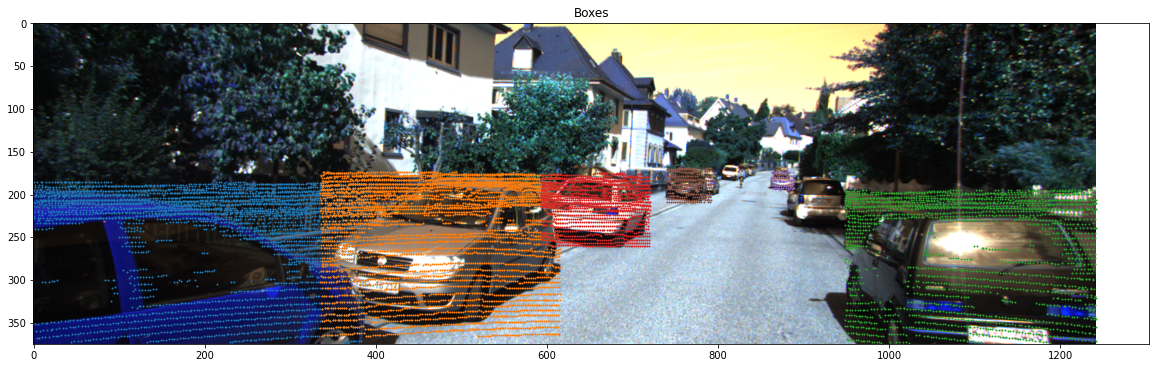

In [10]:
fpn = FPN(1, 1024)

detector = SSD('tmp')
model = PipelineDetector(fpn, 1, detector, 0.5)
predicted_scenes = model.predict(xyzi_test, image_test, calib_test, plot=True)

In [11]:
for det in predicted_scenes[0]:
    print(det)

Detection(xyz=array([-2.6482103 ,  1.50717596,  3.80583394]), angle=-1.1431085788093642, lwh=array([3.75473965, 1.56337061, 1.48549302]), confidence=1.0)
Detection(xyz=array([-1.14097757,  1.59551013,  7.81854143]), angle=1.8836896638302758, lwh=array([3.70307743, 1.57815467, 1.52426267]), confidence=1.0)
Detection(xyz=array([3.97327423, 1.7859312 , 6.24257882]), angle=-1.2997555716905693, lwh=array([3.49153448, 1.51523165, 1.48546356]), confidence=1.0)
Detection(xyz=array([ 1.19625351,  1.66639542, 14.42665937]), angle=-1.2609205811044786, lwh=array([3.7538491 , 1.60663941, 1.49209535]), confidence=1.0)
Detection(xyz=array([20.51268728,  2.1034007 , 54.86306861]), angle=1.892814569645256, lwh=array([3.74516408, 1.63587761, 1.53551721]), confidence=0.9999999)
Detection(xyz=array([ 7.32265551,  1.74557866, 33.37493109]), angle=1.8755878732235889, lwh=array([4.0835545 , 1.68483513, 1.71650293]), confidence=0.9999993)
